# 智能移动机器人：期中作业
唐治江

##### 作业提交
- 代码与报告（1页+）
- 时间：3月23日

### 作业1
##### 目的
- 理解运动传感器和基于航位推算的机器人运动估计方法
##### 数据
- 车轮编码器数据 Wheel encoder data：COMPort_X_20130903_195003.txt
- IMU数据 IMU data：InterSense_X_20130903_195003.txt
##### 基本要求
- 利用车轮编码器数据、 IMU数据和航位推算，计算小车行驶轨迹
- Python/C/C++均可

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
encoder_data = pd.read_csv("./data/COMPort_X_20130903_195003.txt",names=['E', 'Millisecond' ,'1' ,'Count'],header=None, sep=' ',parse_dates=[0])
encoder_data = encoder_data[['Millisecond'  ,'Count']]
encoder_r = 0.003846154
encoder_data['Delta_Count'] = encoder_data['Count'].diff()
encoder_data.loc[encoder_data['Delta_Count'] < -15000, 'Delta_Count'] += 30000
encoder_data['Displacement'] = encoder_data['Delta_Count'] * encoder_r

imu_data = pd.read_csv("./data/InterSense_X_20130903_195003.txt",names=['IMU', 'Millisecond', '0', '1' ,'Roll_Angle' ,'Pitch_Angle' ,'Heading_Angle'], sep=' ',header=None, parse_dates=[0])
imu_data['Heading'] = np.radians(imu_data['Heading_Angle'])
encoder_r = 0.003846154
data = pd.merge_asof(encoder_data[['Millisecond','Displacement']].sort_values(by='Millisecond'),imu_data[['Millisecond','Heading']].sort_values(by='Millisecond'),on='Millisecond', direction='nearest').dropna()
# data

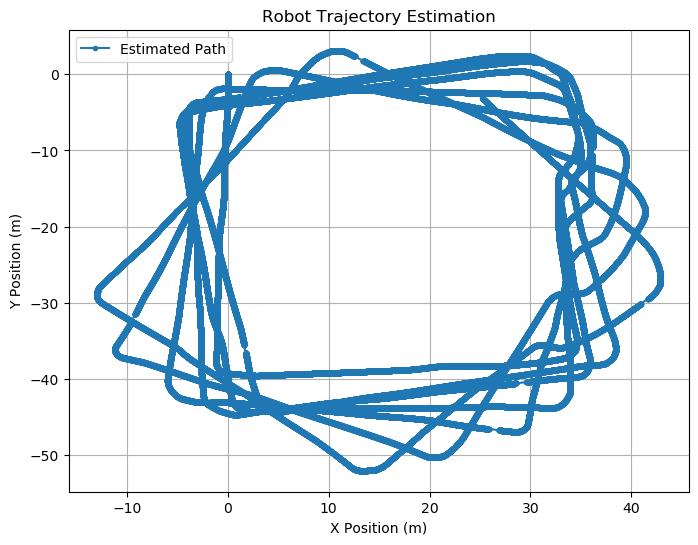

In [2]:

# 运动不确定性模型
def sample_motion_model(u, x, alpha):
    delta_rot, delta_trans = u
    x_old, y_old, theta_old = x
    alpha1, alpha2, alpha3, alpha4 = alpha

    # 采样噪声
    delta_rot_hat = delta_rot +  np.random.normal(0, alpha1*abs(delta_rot) + alpha2*abs(delta_trans))
    delta_trans_hat = delta_trans + np.random.normal(0, alpha3*abs(delta_trans) + alpha4*abs(delta_rot))

    # 更新位姿
    x_new = x_old + delta_trans_hat * np.cos(theta_old + delta_rot_hat / 2)
    y_new = y_old + delta_trans_hat * np.sin(theta_old + delta_rot_hat / 2)
    theta_new = theta_old + delta_rot_hat

    return x_new, y_new, theta_new

# 轨迹推算
result = {'Millisecond':[data.iloc[0]['Millisecond']],'x':[0.0],'y':[0.0],'theta':[227]}
alpha = [0.01, 0.01, 0.02, 0.02]  # 运动噪声参数

for i in range(1, len(data)):
    x = result['x'][-1]
    y = result['y'][-1]
    theta = result['theta'][-1]
    displacement = data.iloc[i]['Displacement']  # 轮编码器计算出的位移
    Millisecond = data.iloc[i]['Millisecond']
    heading = data.iloc[i]['Heading']  # IMU 提供的航向角（弧度）

    # 计算相对旋转量（航向角变化）
    delta_rot = data.iloc[i]['Heading'] - data.iloc[i-1]['Heading']  # 角度变化量
    u = (delta_rot, displacement)  # 运动指令

    # 计算新状态
    x_new, y_new, theta_new = sample_motion_model(u, (x, y, theta), alpha)
    result['x'].append(x_new)
    result['y'].append(y_new)
    result['theta'].append(theta_new)
    result['Millisecond'].append(Millisecond)

# 可视化轨迹
plt.figure(figsize=(8, 6))
plt.plot(result['x'], result['y'], marker='o', linestyle='-', markersize=3, label="Estimated Path")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Robot Trajectory Estimation")
plt.legend()
plt.grid()
plt.show()


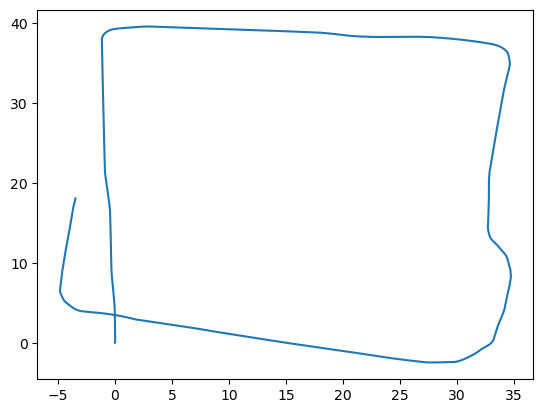

In [3]:
result_df = pd.DataFrame(result)
result_df['roll'] = 0
result_df['pitch'] = 0
result_df['z'] = 0
result_df['y'] = -result_df['y']
result_df.columns
result_df = result_df[['Millisecond','roll', 'pitch','theta', 'x', 'y', 'z']]
result_df = result_df.rename(columns={
    'Millisecond': 'time',
    'roll': 'gtrans.ang.x',
    'pitch': 'ang.y',
    'theta': 'ang.z',
    'x': 'shv.x',
    'y': 'shv.y',
    'z': 'shv.z'
})
end_time = 71554079
result_df = result_df[result_df['time']<=end_time]
# time	gtrans.ang.x	ang.y	ang.z	shv.x	shv.y	shv.z
result_df.to_csv('trajectory.nav',index=False,sep=' ')
plt.plot(result_df['shv.x'].values,result_df['shv.y'].values)

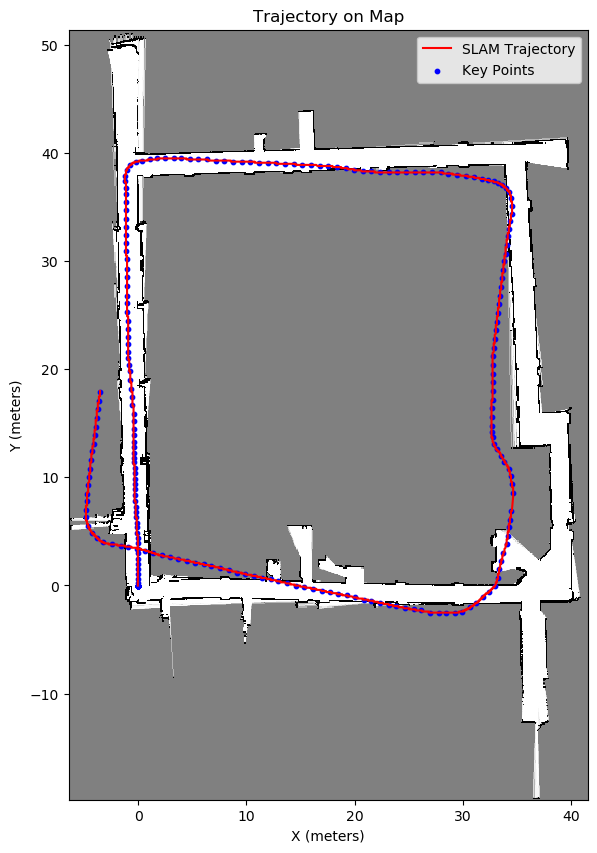

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

class MapNavigator:
    def __init__(self, map_prefix):
        """初始化地图数据"""
        self.map_info = self._load_map_info(f"{map_prefix}.master")
        self.bitmap = self._load_bitmap(f"{map_prefix}.raw")
        
    def _load_map_info(self, master_file):
        """解析地图元数据文件"""
        params = {}
        with open(master_file) as f:
            for line in f:
                if line.strip().startswith('//') or not line.strip():
                    continue
                key, value = line.split()[:2]
                try:
                    params[key] = float(value)
                except ValueError:
                    params[key] = int(value)
        return {
            'width': int(params['width']),
            'height': int(params['length']),
            'origin': (params['ox'], params['oy']),
            'resolution': params['pixelsize']
        }
    
    def _load_bitmap(self, raw_file):
        """加载二进制位图数据"""
        dtype = np.uint8
        bitmap = np.fromfile(raw_file, dtype=dtype)
        return bitmap.reshape((self.map_info['height'], 
                              self.map_info['width']))
    
    def world_to_pixel(self, x, y):
        """世界坐标系转像素坐标系"""
        i = int((x - self.map_info['origin'][0]) / self.map_info['resolution'])
        j = int((y - self.map_info['origin'][1]) / self.map_info['resolution'])
        # Y轴方向转换（地图原点通常对应左下角）
        j = self.map_info['height'] - j - 1  
        return i, j
    
    def plot_trajectory(self, nav_file, save_path=None):
        """在地图上绘制轨迹"""
        plt.figure(figsize=(15, 10))
        
        # 创建带坐标系的图像显示
        extent = [
            self.map_info['origin'][0],
            self.map_info['origin'][0] + self.map_info['width']*self.map_info['resolution'],
            self.map_info['origin'][1],
            self.map_info['origin'][1] + self.map_info['height']*self.map_info['resolution']
        ]
        
        # 显示地图（灰度图处理）
        plt.imshow(self.bitmap, 
                  cmap='gray', 
                  extent=extent,
                  origin='lower',  # 确保Y轴方向正确
                  vmin=0, vmax=255)
        
        # 加载并绘制导航轨迹
        nav_data = pd.read_csv(nav_file, 
                              delim_whitespace=True,
                              usecols=['shv.x', 'shv.y'])
        
        # 转换为像素坐标
        pixels = np.array([self.world_to_pixel(x, y) 
                         for x, y in zip(nav_data['shv.x'], nav_data['shv.y'])])
        
        
        # 过滤越界点
        valid_mask = (pixels[:,0] >= 0) & (pixels[:,0] < self.map_info['width']) & \
                    (pixels[:,1] >= 0) & (pixels[:,1] < self.map_info['height'])
        pixels = pixels[valid_mask]
        
        # 转换为地图坐标系显示
        traj_x = self.map_info['origin'][0] + pixels[:,0] * self.map_info['resolution']
        traj_y = self.map_info['origin'][1] + (self.map_info['height'] - pixels[:,1] - 1) * self.map_info['resolution']
        
        plt.plot(traj_x, traj_y, 'r-', linewidth=1.5, label='SLAM Trajectory')
        plt.scatter(traj_x[::100], traj_y[::100], c='blue', s=10, marker='o', label='Key Points')
        
        plt.title('Trajectory on Map')
        plt.xlabel('X (meters)')
        plt.ylabel('Y (meters)')
        plt.legend()
        
        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()

# 使用示例
if __name__ == "__main__":
    navigator = MapNavigator("./data/ld")
    navigator.plot_trajectory("./trajectory.nav", save_path="trajectory_on_map.png")

### 作业2

##### 目的
- 理解激光雷达数据
##### 数据
- 激光雷达数据 LiDAR data：URG_X_20130903_195003.lms
- 行驶轨迹数据 Vehicle trajectory data：作业1生成的小车行驶轨迹 或 参考文件的ld.nav
##### 要求
- 利用激光雷达及小车行驶轨迹数据，激光点坐标转换、利用简易投票法创建栅格地图（见本PPT的P8-12）
- Python/C/C++均可
##### 作业提交
- 代码与报告（1页+）
- 时间：3月23日

In [5]:
import struct


def parse_lidar_data(file_path):
    with open(file_path, 'rb') as f:
        # 解析头部
        header_fmt = 'fff'
        header_size = struct.calcsize(header_fmt)
        header_data = f.read(header_size)
        ang_rng, ang_res, unit = struct.unpack(header_fmt, header_data)
        max_dat_len = int(ang_rng / ang_res)+ 1

        lidar_data = []
        while True:
            data_fmt = 'I' + 'H' * max_dat_len
            data_size = struct.calcsize(data_fmt)
            chunk = f.read(data_size)
            if len(chunk) < data_size:
                break
            milli, *dat = struct.unpack(data_fmt, chunk)
            # print(len(dat))
            lidar_data.append(([milli] + dat))
    params = {'ang_rng':ang_rng,'ang_res':ang_res,'unit':unit}
    return lidar_data, params

import pandas as pd


def parse_trajectory_data(file_path):
    df = pd.read_csv(file_path, delim_whitespace=True)
    return df

In [6]:
lidar_data, params = parse_lidar_data('./data/URG_X_20130903_195003.lms')
lidar_data_df = pd.DataFrame(lidar_data)
lidar_data_df = lidar_data_df.rename({0:'time'},axis=1)
trajectory = parse_trajectory_data('./data/ld.nav')
data = pd.merge_asof(trajectory.sort_values(by='time'),lidar_data_df.sort_values(by='time'),on='time', direction='nearest').dropna()
data = data.set_index('time')
# data.head(),params

In [7]:
# --------------------------
# 3. 坐标转换核心函数
# --------------------------
def lidar_to_world(data, params):
    """将激光点转换为世界坐标系"""
    world_points = []

    for timestamp in range(len(data)):
        pose = data.iloc[timestamp,list(range(6))]
        ranges = data.iloc[timestamp,list(range(6,367))].values
        
        # 极坐标转笛卡尔
        angles = np.radians(np.arange(len(ranges)) * params['ang_res'])
        x_lidar = ranges / params['unit'] * np.cos(angles)
        y_lidar = ranges / params['unit'] * np.sin(angles)
        
        # 坐标系变换
        theta = pose['ang.z']
        rot_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ])
        points = np.vstack([x_lidar, y_lidar]).T
        rotated = np.dot(points, rot_matrix)
        
        # 平移变换
        world_x = rotated[:,0] + pose['shv.x']
        world_y = rotated[:,1] + pose['shv.y']
        
        world_points.extend(zip(world_x, world_y))
        
    return np.array(world_points)

world_points = lidar_to_world(data,params)


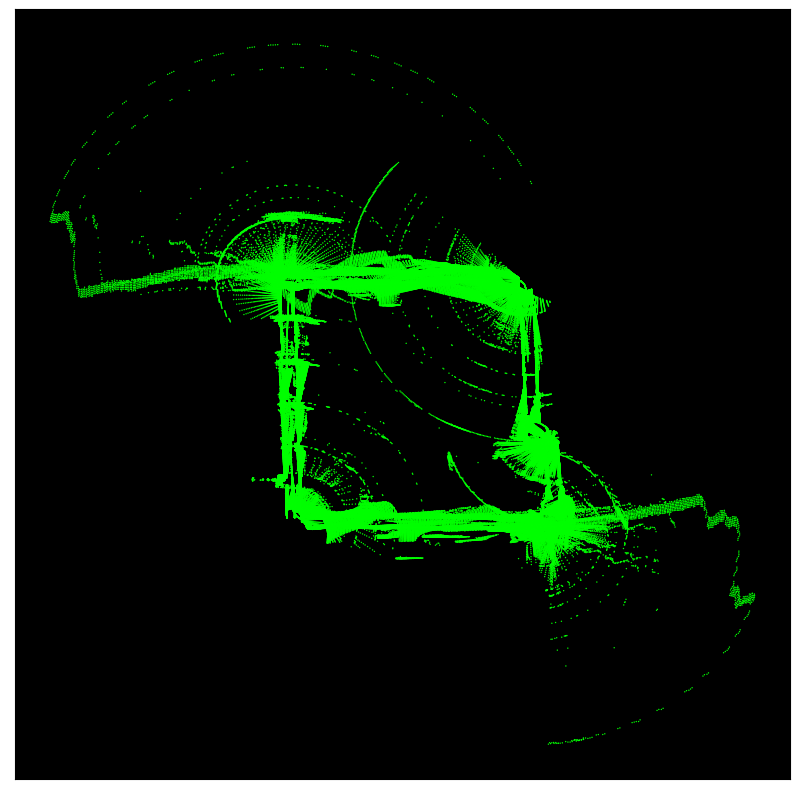

In [8]:
# 设置图像大小
plt.figure(figsize=(10, 10))  # 例如 8x6 英寸

# 绘制散点图
plt.scatter(world_points[:, 0], world_points[:, 1], 
            s=1,  # 点的大小
            color='lime',  # 绿色
            edgecolors='none')  # 移除边缘颜色

# 设置背景为黑色
plt.gca().set_facecolor('black')

# 去除坐标轴（可选）
plt.xticks([])
plt.yticks([])

# 显示图像
plt.show()


In [9]:
def create_grid_map(points: np.array, grid_size=0.1):
    """生成带坐标信息的栅格地图"""
    # 计算固定范围的网格边界
    x_min, x_max = points[:,0].min(), points[:,0].max()
    y_min, y_max = points[:,1].min(), points[:,1].max()
    
    # 生成均匀分布的网格边界
    x_edges = np.arange(x_min, x_max + grid_size, grid_size)
    y_edges = np.arange(y_min, y_max + grid_size, grid_size)
    
    # 统计点云分布
    grid, _, _ = np.histogram2d(
        points[:,0], points[:,1],
        bins=[x_edges, y_edges]
    )
    
    return grid.T, x_edges, y_edges  # 转置矩阵以对齐坐标系

# 创建栅格地图
grid_size = 0.2
grid_map, x_edges, y_edges = create_grid_map(world_points,grid_size=grid_size)


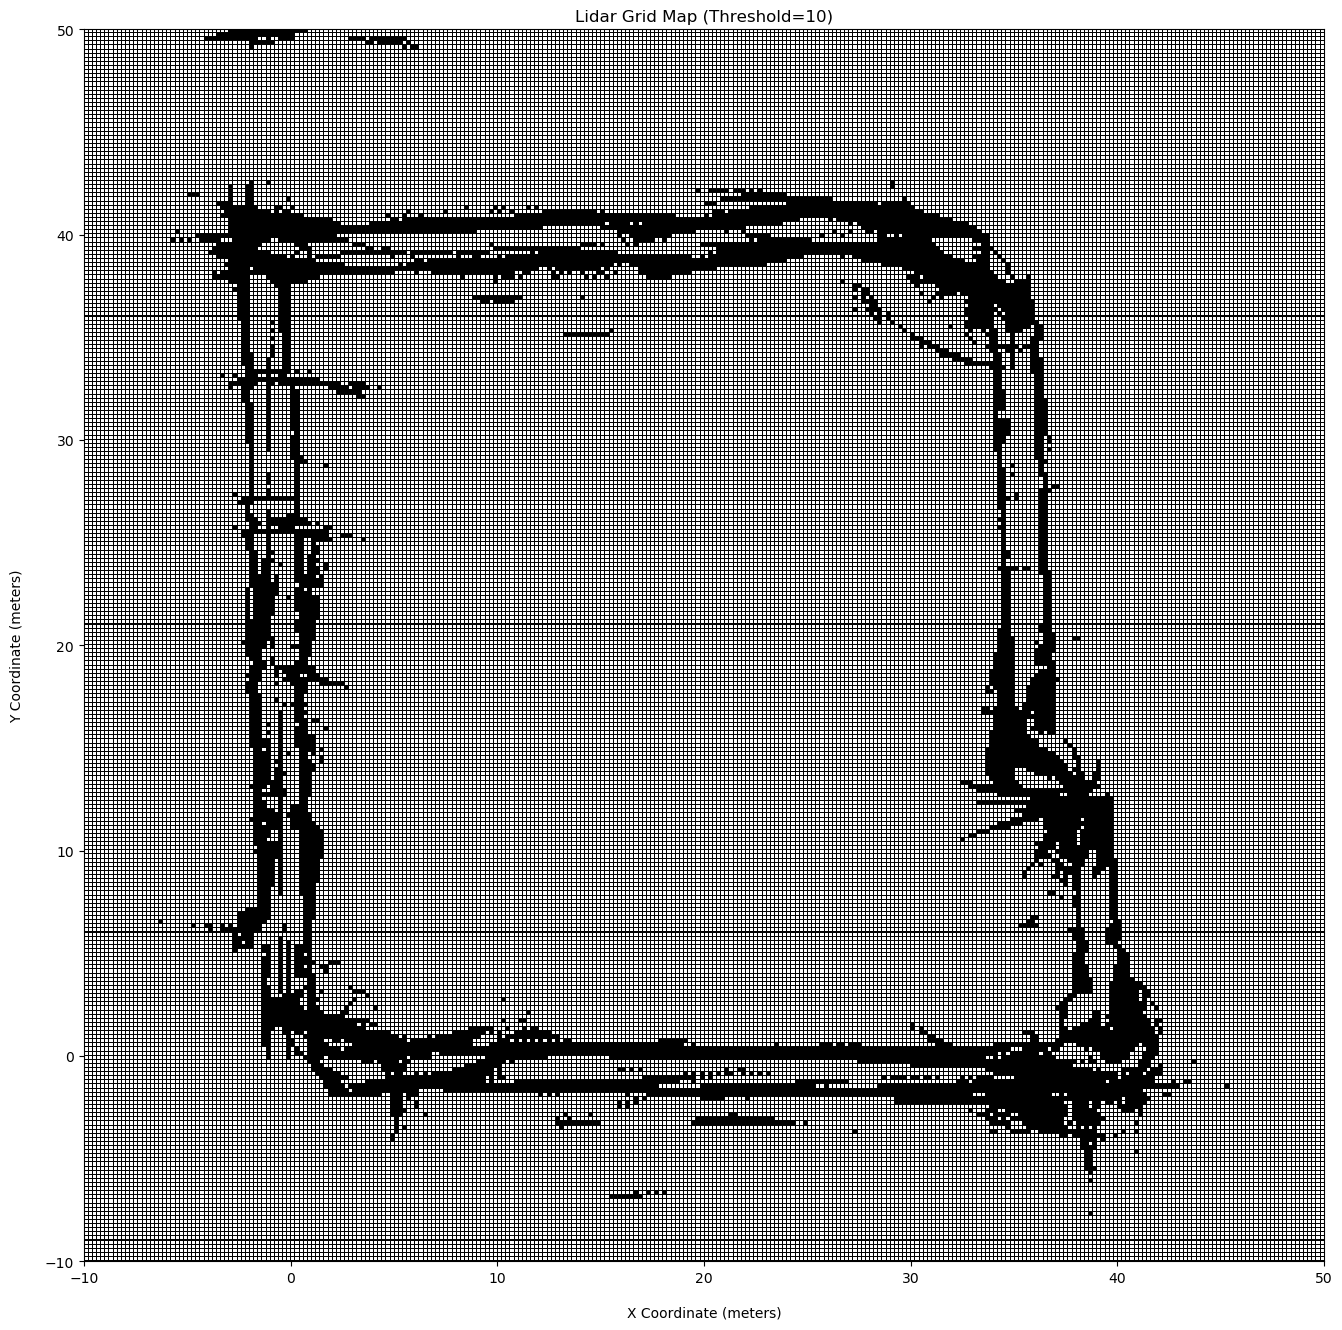

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --------------------------
# 可视化设置
# --------------------------
cmap = plt.cm.binary  # 获取binary颜色映射
cmap.set_over('black')  # 设置超出阈值部分为黑色
hit_threshold = 10  # 超过80次的区域显示为黑色
x_range = [-10, 50]     # X轴显示范围
y_range = [-10, 50]       # Y轴显示范围

grid_map[grid_map<hit_threshold] = 0
# 2. 设置可视化范围
plt.figure(figsize=(16, 16))
ax = plt.gca()
# 创建带网格线的伪彩色图
mesh = plt.pcolormesh(x_edges, y_edges, grid_map,
                     cmap=cmap,
                     edgecolors='k',  # 网格线颜色
                     linewidth=0.01,   # 网格线宽
                     norm=mcolors.Normalize(vmin=0, vmax=hit_threshold),
                     shading='auto')  # 自动优化显示

ax.set_xlim(x_range)
ax.set_ylim(y_range)
plt.title('Lidar Grid Map (Threshold={})'.format(hit_threshold))
plt.xlabel('X Coordinate (meters)', labelpad=15)
plt.ylabel('Y Coordinate (meters)', labelpad=15)
plt.show()
